<a href="https://colab.research.google.com/github/tlmakinen/CEH/blob/main/sparse_reg_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SKIM Pairwise Sparse Regression for exploratory data

Here we'll introduce a (modified) implementation of the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). We'll walk through what we seek to learn from unmapped high-dimensional data, and apply it to both a toy and exploratory example using (circa April 2020) COVID-19 data. 
___

note: to get the most out of this walkthrough, set the Colab Notebook execution type to "GPU" ! SKIM is optimized via Jax vectorization to sample with lightning speed on a single (virtual) GPU.
___

## Sparse Interactions
 
- What are sparse interactions ? 

In high dimensional data (such as hologenomic datasets), researchers are posed with an issue: which aspects or measurements of a dataset form the best predictors for a given observable ? In systems with as many variables as biological experiments, searching for sparse interactions between dataset features can help researchers narrow down analyses to the most important aspects of their data. For instance, human genomic data can contain records of hundreds of active genes, but the observable, e.g. a specific hair color, might only be the result of the presence of a single gene.

- How do we fit dataset features ?

Let's consider, as Agrawal et al. do, a dataset $\mathcal{D} = \{(x^{(n)}, y^{(n)}) \}_{n=1}^{N}$ with $N$ feature vectors (covariates) $x^{(n)} \in \mathbb{R}^p$ and $N$ real-valued responses, or observables $y^{(n)} \in \mathbb{R}$. 
  
The naïve solution is to construct linear relationships between a set of features $\{x \}_i$ 
 $i=1, \dots, p$, and a given outcome, $y$. However, in practice one often encounters scenarios where a *combination* of features is in fact the best predictor for $y$. The natural thing to do is expand the regression problem to the system
$$ \Phi^T_2(x) = [1 + x_1 + \dots + x_p + x_1x_2 +\dots + x_{p-1}x_p, x^2_1, \dots, x^2_p] $$
which considers all pairwise and quadratic terms in the expansion. The regression then boils down to finding coefficients $\theta \in \mathcal{R}^{p(p+1)/2}$ for all terms, yielding a predictive model
$$y^{(n)} = \theta^T \Phi_2 (x^{(n)}) + \epsilon^{(n)} $$

Where $\epsilon^{(n)}$ are zero-centered i.i.d. errors. We're now interested in figuring out which interaction terms best describe the response. By encouraging sparsity (assuming only a few covariates explain the response), the problem becomes at once *easier* statistically, but *harder* computationally, since maximizing a likelihood for $\theta$ with sparse $L_1$ constraints takes $\mathcal{O}(np^2)$ time.

---

## Bayesian Interaction Sampling
Fortunately, Bayesian hierarchical methods incorporate model shrinkage naturally, even if they are computationally expensive in a naïve setting. We're interested in recovering the posterior distribution for our coefficients $\theta$, given as:
$$ p(\theta | \mathcal{D}) \propto \mathcal{L}(Y | \theta, X) p(\theta) $$
where $\mathcal{L}(Y | \theta, X)$ is the likelihood of seeing observable $Y$ given model parameters, and $p(\theta)$ is the prior, or an encoding of the state of knowledge about the parameters *before* observing the data.

To do this, we need to posit a generative model for the data. The SKIM model assumes a Gaussian scale mixture model for $y$:
\begin{align}
\tau &\sim p(\tau) \\
\sigma^2 &\sim p(\sigma^2) \\
\theta | \tau &\sim \mathcal{N}(0, \Sigma_\tau) \\
y^{(n)} | x^{(n)}, \theta, \sigma^2 &\sim \mathcal{N}(\theta^T \Phi_2(x^{(n)}), \sigma^2)
\end{align}
 Where $\Sigma_\tau$ is the covariance matrix for $p(\theta | \tau)$. 
- Define linear + pairwise interaction terms
- introduce sampler + hierarchical model


## SKIM Model
The SKIM model presented by Agrawal et al. circumvents computational intractability in both the sparse and Bayesian settings by utilizing a Kernel Interaction sampler to highlight relevant features in the data, followed by the "Kernel Interaction Trick" to recover the posterior marginal distributions of the relevant active dimensions. Full details are given in the paper, but we'll proceed with a couple examples to illustrate the method in an exploratory setting. 
 
--

***

### How does the SKIM model promote sparsity ?

Based on Griffin and Brown (2017), hierarchical priors in Bayesian regression are dependent on the size of the coefficients, where the hyperparameters control for shrinkage of coefficients similar to a penalty term. In particular, a small estimated variance in coefficients would enforce some shrinkage and likely yield a sparser model. The Gaussian scale mixture is just a special case of hierarchical priors, in which $\tau$ and $\Sigma_\tau$ control the shrinkage of $\theta$. The SKIM model, in particular, has the form
\begin{align}
\kappa \sim p(\kappa)&, \quad \eta \sim p(\eta), \quad c^2 \sim p(c^2) \\
 \theta_{x_i} | \kappa, \nu &\sim \mathcal{N}(0,\eta_{1}^{2} \kappa_{i}^{2}) \quad \text{independent for} \quad i\in\{1,...,p\}, \\
\theta_{x_i x_j} | \kappa, \eta &\sim \mathcal{N}(0, \eta_{2}^{2}\kappa_{i}^{2}k_{j}^{2}) \quad \text{independent for} \quad i,j\in\{1,...,p\}, i \neq j, \\
\theta_{x_{i}^{2}} | \kappa,\eta &\sim \mathcal{N}(0,\eta_{3}^{2}\kappa_{i}^{4}) \quad \text{independent for}\quad i\in\{1,...,p\}, \\
\theta_{0}|c^2 &\sim \mathcal{N}(0,c^2).
\end{align}

The pdfs $p(\kappa), p(\nu)$ and $p(c^2)$ are usually chosen to be heavy-tailed. 

First, the model above promotes sparsity on the parameter $\theta_{x_i}$ for $i\in\{1,...,p\}$. The parameter $\eta_1$ controls the overall sparsity level of the $\theta_{x_i}$. If $\eta_1$ is small, then, $\eta_{1}^{2}\kappa_{i}^{2}$ tends to be small for each $i\in\{1,...,p\}$, leading to a very high probability mass of the normal density of $\theta_{x_i}$ around zero. Therefore, realizations of $\theta_{x_i}$ where $|\theta_{x_i}|$ is small tend to be more likely. The parameter $\kappa_i$, which is usually drawn from a heavy-tail distribution, controls for the local sparsity and can then overcome the global shrinkage induced on $\theta_{x_i}$ by $\eta_1$ if the realization of $\kappa_i$ is large enough. If the realization of $\kappa_i$ is large enough, the variance $\eta_{1}^{2}\kappa_{i}^{2}$ of $\theta_{x_i}$ can become non-negligible, leading to a higher likelihood of non-zero values for $|\theta_{x_i}|$. 

Secondly, the model promotes sparisty by its hirarchy property. In this context, hirarchy means that an interaction terms $\theta_{x_i x_j}$  can only be relevant if both $\theta_{x_i}$ and $\theta_{x_j}$ are relevant. Thus, if at least one of the parameter $\theta_{x_i}$ or $\theta_{x_j}$ are shrunk to zero, the interaction term $\theta_{x_i x_j}$ is shrunk to zero too. This can be seen by observing that the variance of the interaction term $\theta_{x_i x_j}$ is given by $\eta_{2}^{2}\kappa_{i}^{2}\kappa_{j}^{2}$. If at least one of the local parameter $\kappa_{i}$ or $\kappa_j$ is small, then, the variance of $\eta_{2}^{2}\kappa_{i}^{2}\kappa_{j}^{2}$ will be small, leading to a high likelihood concentration of $\theta_{x_i x_j}$ around small values of $|\theta_{x_i x_j}|$. Here again, the parameter $\eta_2$ controls for the global sparsity of the interaction terms $\theta_{x_i x_j}$. We see the sparsity in $\theta_{x_i}$ are "inherited" via hirarchy to sparsity in $\theta_{x_i x_j}$. 

The above applies similarly for the quadratic terms $\theta_{x_i}^{2}$. If the local shrinkage parameter $\kappa_i$ tends to be small, then, the variance of $\theta_{x_i}^{2}$, which is given by $\eta_{3}^{2}\kappa_{i}^{4}$ will be small. Again, the parameter $\eta_3$ controls for the global sparsity of the interaction terms. 

<!-- ### Question 2:

This result is possible due to the Proposition 4.1 in Agrawal et al (2019), and the weight-space view of GP from Rasmussen and Williams (2006). The function $\Phi_2$ is designed such that it can be rewritten as a GP, namely the GP $g = \theta^T\Phi_2$. Then, for any draw $g|\tau\sim N(0,k_\tau)$, there exists a parameter vector $\theta$ such that $g=\theta^T\Phi_2$. The model in Eq (3) is equivalent to the model in Eq (6) for the right choice of the kernel function $k_\tau$ for the Gaussian Process $g|\tau \sim \text{GP}(0,k_\tau)$. The choice of the kernel function $k_\tau$ is
$$ k_\tau(x,x') = \Phi_{2}(x)^t \Sigma_\tau \Phi_{2}(x').$$

For such a choice, the model defined in Eq (3) is always equivalent to the model defined in Eq (6). However, for the proposed algorithm to work in the proposed time efficiency, we need to be able to evaluate $k_\tau$ in $O(p)$ time, where $p$ is the number of covariates. To do this, the papaer rewrites the kernel $k_\tau$ as a weighted sum of polynomial kernels. To do this, one one needs to require the variance-covariance matrix $\Sigma_\tau$ of the parameter $\theta$ to be diagonal.  -->

<!-- ### Question 3:

We can identify the following limitations to this paper:

* The implementation of the SKIM model is dependent on the choice of several hyperparameters that need to be selected by the user. Some of these hyperparameter are non-trivial to choose, but at the same time very important. For example, the SKIM model requires the user to select a hyperparameter $s$ which corresponds to the global sparsity of $\theta_{x_i}$. Furthermore, the $\kappa_i$'s are chosen from a truncated half-Cauchy distribution, in which one needs to specify a hyperparameter $m$ that corresponds to the truncation cutoff of the half-Cauchy distribution. Therefore, $m$ control indirectly for the heavy-tailness of $p(\kappa)$ and therefore, for the local sparsity on $\theta_{x_i}$. Similar hyperparameter have to be chosen for the interaction terms $\theta_{x_i x_j}$ and the squared terms $\theta_{x_i}^{2}$. Overall, to sum it up, there are several hyperparameters to select and the choice is not trivial. 

* The implementation of the SKIM model in the paper requires the variance-covariance matrix $\Sigma_\tau$ of the prior of the parameter $\theta$ to be diagonal. Therefore, it is impossible to incorporate correlations between different components of $\theta$ in the prior. 

* The SKIM method implies hirarchy. This is, an interaction parameter $\theta_{x_i x_j}$ is always negligable if at least one of the parameter $\theta_{x_i}$ and $\theta_{x_j}$ is negligable. This is a desirable property in many applications. However, in certain applications, this property might not be desirable. Consider a situation in which both variables $x_i$ and $x_j$ do not directly influence the target variable $y$, however, their interaction term $x_i x_j$ has strong predictive power. This situation cannot be reflected by the SKIM method. 
    - For a specific example, in the discussion of Priors for Related Predictors in Chipman (1996), one practical instance in which the strong hierarchy property would fail is in atmospheric sciences. A key relation is $log(Y)=log(A)+BC$, in which the interaction term $BC$ would not satisfy strong hierarchy, and thus could not be properly modeled using this approach. 

* The SKIM method, as implemented in the paper, takes $O(pN^2 + N^3)$ time to compute, where $N$ denotes the number of observations and $p$ the number of covariates. It has the nice property of scaling linearly in $p$, which makes the method applicable to situations in which $p$ is large. However, the method scales cubic in $N$. This limits the applicability of the method to situations in which $N$ is large. By comparison, the naive method requires $O(p^6 + p^4 N)$ time, which scales linearly in $N$ (but obviously, terrible in $p$). Furthermore, memory is quadratic with respect to $N$, which is only as good or even worse than the other sampling methods compared (NAIVE, WOODBURY, and FULL). 

* The method is based on sampling $\tau_1,...,\tau_T \sim p(\tau | D)$ iid. To do so, MCMC methods are used. Therefore, the drawback that are specific to MCMC methods apply to this method too. Particularly, these are deciding when convergence of the Monte Carlo chain underlying the MCMC process is reached, how to sparse out the MCMC chain to obtain approximately independent draws and deciding on hyperparameters and initial choices. 

* Another possible limitation is the reliance/assumption of pairwise interactions. On one hand, the dimension of the parameter space is increased from $p$ to $\frac{p(p+1)}{2}$, which could be extremely computationally expensive when $p$ is not even that large; on the other hand, there may be instances that involve higher-order polynomial interactions, and thus this model of at-most pairwise interactions could be too limited in its scope.  -->

***

### Implementing SKIM in jax / Numpyro

I've modified the code from this awesome
[post](https://pyro.ai/numpyro/examples/sparse_regression.html). All sampling routines are contained in the `skim.py` module available on my GitHub (see clone command below).


***

### 1. Transfer the code and check for comparable result

First, we transfer the code to the notebook

In [1]:
!git clone https://github.com/tlmakinen/CEH.git

fatal: destination path 'CEH' already exists and is not an empty directory.


In [2]:
cd CEH/covid_example/

/content/CEH/covid_example


In [3]:
!pip install numpyro

In [4]:
!pip install corner

In [5]:
import argparse
import itertools
import os
import time

import numpy as onp

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import corner

## Import the SKIM method library and create a toy example

Here we create a toy multidimensional dataset of 100 $N_{\rm dim} = 20$ data points. We then choose $S=3$ of these dimensions to be "active"--that is, produce an observable scalar, $Y$. We additionally incorporate two pairwise interactions between dimension 1 and 2, and 2 and 3.

We'll apply the SKIM sampling algorithm to see if we can retrieve this behavior from the data in the presence of the 17 other inactive dimensions, as well as observational noise.

___
**note**: feel free to play with the hyperparameters ! Try different combinations of pairs and numbers of input or active dimensions

In [6]:
# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there are two pairwise interactions
# between the first and second dimensions, and second and third (note: Python
# indexes from 0 => dim 1 is 0th dimension).
def get_toy_data(N=20, S=2, P=10, sigma_obs=0.05, active_pairs=[(0,1), (1,2)]):
    assert S < P and P > 1 and S > 0

    onp.random.seed(0)

    X = onp.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * onp.random.rand(S)
    # generate data using the S coefficients and however many pairwise interactions

    Y = onp.sum(X[:, 0:S] * W, axis=-1) 

    # now add in all pairwise interactions
    for pair in active_pairs:
    	Y += X[:, pair[0]] * X[:, pair[1]] 

    Y += sigma_obs * onp.random.randn(N)
    Y -= np.mean(Y)
    Y_std = np.std(Y)

    assert X.shape == (N, P)
    assert Y.shape == (N,)

    return X, Y / Y_std, W / Y_std, 1.0 / Y_std

sample: 100%|██████████| 1500/1500 [00:40<00:00, 36.61it/s, 15 steps of size 2.15e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.01    314.30      1.00
 lambda[0]    828.38   6719.81    204.43     21.77   1019.27    943.37      1.00
 lambda[1]   2710.23  17679.72    431.47     40.47   3117.46    450.68      1.00
 lambda[2]    542.45   4712.14    141.35     12.05    726.62    590.80      1.00
 lambda[3]      1.23      1.83      0.70      0.00      2.69    572.17      1.00
 lambda[4]      1.26      1.73      0.75      0.01      2.86   1014.16      1.00
 lambda[5]      1.11      1.42      0.72      0.00      2.46    949.72      1.00
 lambda[6]      1.24      1.65      0.72      0.00      2.91   1292.41      1.00
 lambda[7]      1.18      1.65      0.69      0.00      2.72   1077.87      1.00
 lambda[8]      1.09      1.33      0.64      0.00      2.51    950.95      1.00
 lambda[9]      1.19      1.42      0.75      0.00      2.82    961.55      1.00
lambda[10]      1.24      1

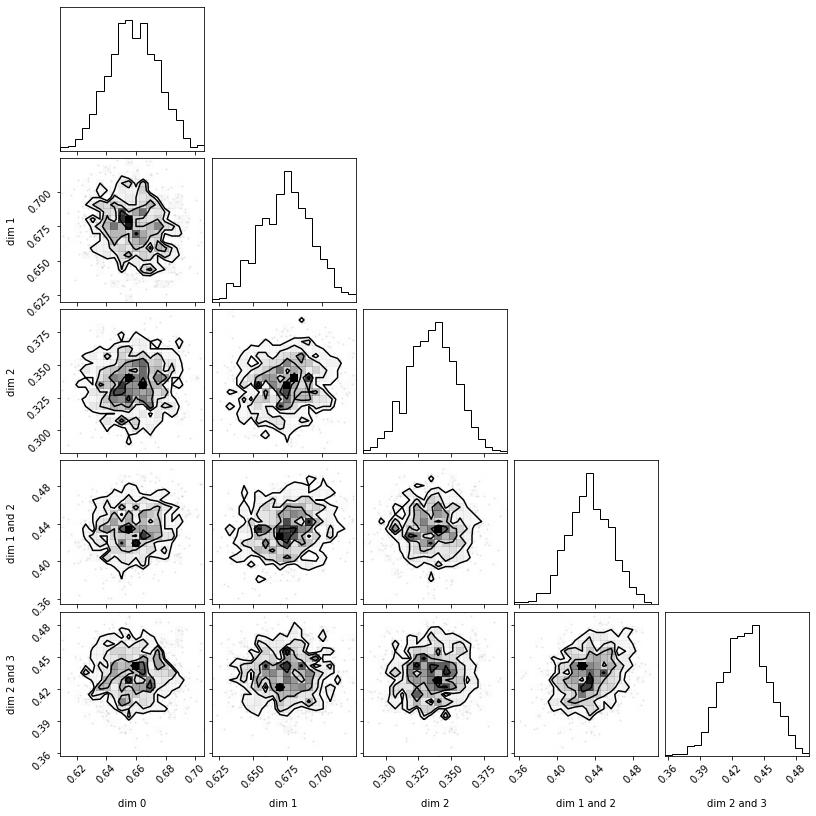

In [7]:
import skim

# define the parameters for the initialization
num_dimensions=20; active_dimensions=3; num_data=100; labels=None; N_samps = 1000; num_chains=1
    

X, Y, expected_thetas, expected_pairwise = get_toy_data(N=num_data, P=num_dimensions,
                                                        S=active_dimensions)

hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
              'sigma' : 3.0,
              'alpha1': 3.0, 'beta1': 1.0,
              'alpha2': 3.0, 'beta2': 1.0,
              'alpha3': 1.0, 'c': 1.0,
              'alpha_obs': 3.0, 'beta_obs': 1.0}

skim_model = skim.SKIM(X, Y, hypers, seed=0)

all_active_dimensions, thetas, labels, pair_labs = skim_model.generate_posterior(known_active_dimensions=3, labels=None)
fig = corner.corner(thetas, labels = labels)

So we were able to recover the toy simulation inputs ! SKIM does a good job of picking out non-negligible contributions to the observable, $Y$.
___

# Practical Example: COVID-19 mortality rate (circa May 2020)



***

**Note**: COVID-19 dataset collection and this initial study was conducted for Princeton University's SML 515 course (taught by Peter Melchior). Collaboration included: 

* Aizhan Akhmetzhanova 
* Tony Chen
* Lucas Makinen
* Emre Oezkan
* Sachin Smart

***

### The Target Variable ($Y$-variable)

The goal of this exercise is to identify explanatory variables that are expressive in the Covid-19 mortality rate across different countries. To do so, we consider a regression setup in which the Covid-19 mortatility rate is our target variable ($y$-variable). We interpret the realization of the target variable for any given country as an observation (or sample). 

We source the Covid-19 mortality rate across countries from the John-Hopkins website. We have the death rate available for a total of 144 countries. We take a first look into the $y$-variable which is the Covid-19 mortality rate.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
y_var = pd.read_csv("JHU_recent_mortality_by_country.csv", 
                    converters = {"Case-Fatality": lambda x: float(x.strip("%"))/100})

(y_var.head())

,Country,Case-Fatality
0,US,0.059
1,United Kingdom,0.150
2,Italy,0.138
3,Spain,0.117
4,France,0.150


We derive the basic sample statistics for our target variable.

In [10]:
y_var.describe()

,Case-Fatality
count,144.000000
mean,0.047083
std,0.043048
min,0.001000
25%,0.018000
50%,0.035500
75%,0.061000
max,0.312000


We make the following observation:

* The standard-deviation of the mortality is relatively high.
* The mortality ranges from ~0.1% to ~30%. This is a very wide range.

We plot the histogram for the mortality to get a sense for the distribution of our target variable.

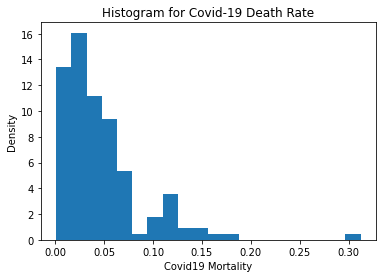

In [11]:
plt.hist(y_var.iloc[:,1], density = True, bins = 20)
plt.ylabel("Density")
plt.xlabel("Covid19 Mortality")
plt.title("Histogram for Covid-19 Death Rate");

### The Explanatory Variables ($X$-data)

Our goal is to construct a regression model in which we predict the target variable. To do so, we need to come up with a set of explanatory variables that is expressive in predicting the Covid19 mortality rate. The data on the explanatory variables should be available for as many countries as possible, to create a data set of $X$-and $y$-data that is large enough.

Our approach is to come up with explanatory variables that we intuitively think are important to predict the Covid-19 rate. Then, we try to find data on these explanatory variables for as many countries as possible on the internet. We used the following sources for our data:

* World Health Organization (WHO),
* Wikipedia,
* worldindata.com,
* worldometer.com.

<!-- 
We source each explanatory variable from the internet in separate .csv files. Then, we use our data compilation code to combine all the different .csv files into one large .csv file, which we call "raw_data.csv". Please refer to the data compilation algorithm in the separate .ipynb file.  -->

Load the .csv file containing the combined data sets. 

In [12]:
jhu = pd.read_csv("raw_data.csv")

These are the explanatory variables that we consider in order to predict the Covid19 mortality rate.

In [13]:
pd.DataFrame(jhu.columns[2:], columns = ["Variables"])

,Variables
0,Human Development Index (HDI)
1,Population median age (years)
2,Adult mortality rate
3,Life expectancy at birth (years)
4,Mortality rate attributed to exposure to unsaf...
5,Population proportion over 60 (%)
6,Current health expenditure (CHE) per capita in...
7,UHC index of service coverage (SCI)
8,Cases per 1M population
9,Urban population (% of total population)


In [14]:
jhu.columns[2:].tolist()

['Human Development Index (HDI)',
 'Population median age (years)',
 'Adult mortality rate',
 'Life expectancy at birth (years)',
 'Mortality rate attributed to exposure to unsafe WASH services',
 'Population proportion over 60 (%)',
 'Current health expenditure (CHE) per capita in US$',
 'UHC index of service coverage (SCI)',
 'Cases per 1M population',
 'Urban population (% of total population)',
 'diabetes_prevalence',
 'hospital_beds_per_100k',
 'cvd_death_rate',
 'GDP per capita',
 'Tests/ 1M pop']

The explanatory variables that we consider can be classified as follows:

* Demographic data (population median age, population proportion over 60%, urban population),
* Economic indicators (GDP per capita),
* Health care related indicators (adult mortaility rate, life expectancy at birth, mortality rate attributed to exposure to unsafe washing practices, health care expenditure per capita, diabetes prevelance, hospital beds per capita, CVD death rate),
* Covid-19 related indicators (Coronavirus cases per capita, Covid19 test rate),
* Indices that reflect a combination of economic, heatlh care and demographic information (Human Development Index, UHC index).

The justifications for these variables are as follows:

- **HDI**: More developed countries are better equipped to handle a large-scale health crisis, so may be better able to reduce the mortality rate.
- **Median age**: COVID-19 appears to be affecting the elderly more than the young, so an older population may be more likely to have a higher mortality rate.
- **Mortality rate**: Deaths from COVID-19 might be mistaken for other causes (or vice versa) in the early reporting so there could be relationship between overall mortality rate and COVID-19 mortality rate. Also countries like Belgium are including deaths of people who have not been tested but are suspected of having had COVID-19 in their COVID-1 death tallies.
- **Mortality rate (unsafe WASH)**: A key part of the COVID-19 prevention guidelines is regular and thorough washing / cleansing; thus, if a country already has deaths from poor access to water, sanitation, and hygiene services, it is more likely to be difficult to 'flatten the curve' in that country.
- **Population 60+**: Similar to median age.
- Current health expenditure (CHE): Countries that spend more on healthcare are perhaps more likely to be able to handle a large-scale health crisis.
- UHC index: Similar to CHE -- countries with better access to necessary health services are perhaps more likely to be able to handle a large-scale health crisis.
- **Cases per 1M**: This is (roughly) the denominator of the mortality rate so is closely linked. More cases may mean more moderate cases of COVID-19 have been found so the mortality rate may be lower. Alternatively, more cases may just mean the severity of the spread is higher and so the mortality rate could be higher because the pandemic is worse in that country.
- Urbanisation: More urban environments are more densely-packed and so contact / spread is more likely: people use public transport, live in apartment buildings, eat out at restaurants more, go to the same parks, etc.
- **Diabetes**: COVID-19 does affect the more vulnerable portions of the population more, but this is also one (rudimentary) indicator of the pre-COVID-19 health of the population: more diabetics might indicate a generally less healthy population.
- **Hospital beds**: The issues of insufficient hospital beds and ventilators and PPE have been all over the news for weeks as hospitals are overrun with COVID-19 patients. More hospital beds may indicate a country is better able to handle the pandemic and maybe also just better prepared generally.
- **COVID-19 death rate**: This is of course linked to the COVID-19 mortality rate, so we feel it could be a good explanatory variable.
- **GDP**: Similar to HDI.
- Tests / 1M: The number of tests relates to the number of cases as more tests will lead to more positive results. Additionally, more tests may indicate a country's responsiveness to the crisis.


## A note on chosen variables:
Some of the chosen features of our dataset are likely compound statistics (that is, functions of one another). For example, countries with higher GDP can be expected intuitively to have higher HDI and public health systems, yielding a higher number of tests per million people.

We might uncover an intuitive, hierarchical relationship via our sampling method ...

<!-- As described above, the explanatory data is obtained from different sources from the internet. Depending on the source, the information on any given explanatory variable is not always available across all countries. Furthermore, the data is sometimes not clean. Thus, we need to clean the data and deal with missing values. To do so, we have a data cleaning process in-place. The process follows the following logic: -->

<!-- * If any country has less than 90% of the data on the variables available, the country is dropped. This is to exclude countries that have too few information available.
* If a variable has less than 70% of the data across countries available, then, the variable is dropped. 
* Countries belonging to the lower 40-percentile in terms of population size 
are dropped. This is because we deem small countries to not be representiative and the information too noisy. 
* We fill any remaining NA using a data imputation algorithm. The data imputation algorithm is based on predicting missing data with a linear regression and pruning the prediction with the sample median and sample median absolute deviation. -->

We laod the clean data set and take a first look.

In [15]:
jhu.head()

,Country,Case-Fatality,Human Development Index (HDI),Population median age (years),Adult mortality rate,Life expectancy at birth (years),Mortality rate attributed to exposure to unsafe WASH services,Population proportion over 60 (%),Current health expenditure (CHE) per capita in US$,UHC index of service coverage (SCI),Cases per 1M population,Urban population (% of total population),diabetes_prevalence,hospital_beds_per_100k,cvd_death_rate,GDP per capita,Tests/ 1M pop
0,US,0.059,0.920,37.4,114.0,78.5,0.2,195.6,10246.1,84.0,3763.0,82.256,10.79,2.77,151.089,59928.0,23522.0
1,United Kingdom,0.150,0.920,40.2,67.0,81.4,0.2,45.0,3858.7,87.0,3027.0,83.398,4.28,2.54,122.137,44920.0,20385.0
2,Italy,0.138,0.883,44.3,54.0,82.8,0.1,49.7,2840.1,82.0,3560.0,70.438,4.78,3.18,113.151,40924.0,38221.0
3,France,0.150,0.891,40.6,71.0,82.9,0.3,47.4,4379.7,78.0,1982.0,80.444,4.77,5.98,86.060,44033.0,16856.0
4,Belgium,0.159,0.919,41.6,72.0,81.2,0.3,8.0,4507.4,84.0,4403.0,98.001,4.29,5.64,114.898,49367.0,40914.0


We calculate the basic sample statistics on our data set.

In [16]:
jhu.describe()

,Case-Fatality,Human Development Index (HDI),Population median age (years),Adult mortality rate,Life expectancy at birth (years),Mortality rate attributed to exposure to unsafe WASH services,Population proportion over 60 (%),Current health expenditure (CHE) per capita in US$,UHC index of service coverage (SCI),Cases per 1M population,Urban population (% of total population),diabetes_prevalence,hospital_beds_per_100k,cvd_death_rate,GDP per capita,Tests/ 1M pop
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.051574,0.735721,29.580882,144.735294,73.398529,10.235294,34.258824,1403.435294,67.411765,786.823529,62.559838,7.414853,2.830300,239.031368,21761.014706,11243.658348
std,0.039127,0.154303,9.102997,74.459168,7.193602,17.544804,90.781325,2248.267614,15.316789,1088.427922,21.869877,3.535779,2.554781,119.321789,19044.177430,18429.221893
min,0.006000,0.377000,15.000000,49.000000,58.000000,0.050000,0.600000,25.300000,37.000000,2.000000,16.425000,1.820000,0.100000,79.370000,1019.000000,50.000000
25%,0.021750,0.620750,22.125000,79.000000,68.300000,0.200000,3.875000,98.500000,55.000000,56.000000,46.274250,5.235000,1.100000,143.999250,5403.500000,913.500000
50%,0.042000,0.760000,27.750000,128.500000,75.250000,1.000000,8.300000,408.650000,74.000000,165.500000,67.650000,6.965000,1.950000,222.984000,15492.500000,3261.106915
75%,0.066750,0.859250,38.725000,182.750000,77.975000,13.750000,26.000000,1363.250000,78.250000,1426.500000,80.527500,9.020000,3.660000,286.210750,30581.500000,14308.500000
max,0.159000,0.946000,45.900000,334.000000,84.200000,70.800000,646.000000,10246.100000,89.000000,4403.000000,98.001000,17.720000,13.050000,597.029000,74035.000000,121330.000000


### A First Look into Variable Selection: The Lasso

Before applying the SKIM method to our data set, we want to get a first impression on which of the explanatory variables might be important to predict our target variable. We apply Lasso to the data set to do so. Lasso is a regression method that adds a $l_1$-penalty to the sum-of-squares error to obtain a sparse coefficient vector. More specifically, the Lasso coefficients is the solution of 
$$ \min_{\beta\in\mathbb{R}^d} \frac{1}{2n} || y - X\beta||_{2}^{2} + \alpha ||\beta||_{1}.$$
Depending on the magnitude of the hyperparameter $\alpha$, which controls for the $l_1$-penalty, we obtain a lasso coefficient vector $\hat{\beta}_\text{Lasso}$ with variying degree of sparsity. Now, we can solve this Lasso problem for varying levels of the $\alpha$. In this way, we can begin our analysis with a completely sparse coefficient vector and reduce the sparsity in each step to include explanatory variables step-by-step. This is called the **Lasso path**. In the following, we calculate the Lasso path.

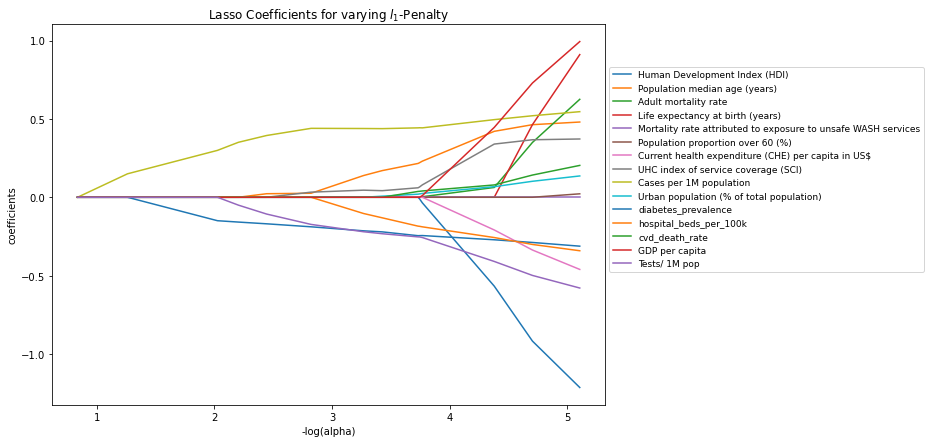

In [17]:
##############################################################################
#Lasso heuristics
##############################################################################

#define X and y variable set
X = np.array(jhu.iloc[:,2:])
Y = np.array(jhu.iloc[:,1])

#standardize data
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
Y = StandardScaler().fit(Y.reshape(-1,1)).transform(Y.reshape(-1,1)).ravel()

#apply Lasso path
from sklearn.linear_model import lars_path
alphas, active, coef_path_lars = lars_path(X, Y, method='lasso')

#define pd data frame with active coefficients
var_sel = pd.DataFrame(coef_path_lars, index = jhu.columns[2:],
                       columns = onp.vectorize(lambda x: "alpha= "+str(round(x,2)))(alphas))    

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for i in range(var_sel.shape[0]):
    ax.plot(-np.log(alphas[:-1]), var_sel.iloc[i,:-1])

plt.title("Lasso Coefficients for varying $l_1$-Penalty")
plt.xlabel("-log(alpha)")
plt.ylabel("coefficients")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.99, box.height])

# Put a legend to the right of the current axis
ax.legend(jhu.columns[2:], bbox_to_anchor=(1.0, 0.9),fontsize=9)
plt.show()


With varying degrees of $l_1$-penalty, the Lasso selects the following variables in the following order:

In [18]:
pd.DataFrame(jhu.columns[2:][active], columns = ["Lasso Selection"])

,Lasso Selection
0,Cases per 1M population
1,diabetes_prevalence
2,Tests/ 1M pop
3,Population median age (years)
4,UHC index of service coverage (SCI)
5,hospital_beds_per_100k
6,Urban population (% of total population)
7,cvd_death_rate
8,Human Development Index (HDI)
9,Adult mortality rate


Based on this Lasso-based variable selection process, has idenitfied the following variables as important:

* Number of Coronavirus cases per capita, 
* The diabetes prevalance,
* Coronavirus testing rate.

Remarkably, the Lasso identified both Covid-19 related indicators. This makes intuitive sense. With a low Coronavirus testing rate, more severe cases are being tested, introducing a positive bias in the Covid19 mortatility. 

# Applying SKIM to COVID Data
Next, we will apply the SKIM method to our data set to obtain distributions of relevant covariates.

We found that the out-of-the box hyperparameters given in the example code for the toy sparsity problem were unable to capture the massive variance in parameter prediction that we recovered after a couple of naive runs. The result was no reported active dimensions or pairwise interactions, even though the data possess strong qualitatively-correlated trends.

To mitigate this, we ran a Sequential Model-Based Optimization scheme on the Inverse Gamma hyperparameters using the package HyperOpt on an HPC cluster. We probed log-uniform hyperparameter space, making $-\exp(N_{\rm active})$ our loss criterion, where

$$N_{\rm active} = \text{num active dims + num pairwise active dims}$$

SKIM relies on a global hyperparameter, $\sigma$, which expresses the number of standard deviations of non-zero bins around a sampled covariate mean are required to consider said variable to be "properly sampled". Relaxing the sigma bound intuitively allows for a greater number of active dimensions to be recovered, although their effect on the actual observable will be weaker.


For the hyperparameter search we relax the built-in criterion for counting active dimensions to be a well-sampled distribution (no zero bins) within $\pm1.5 \sigma$ of the mean of the parameter contour estimate. The result of our optimization run was a set of rather unintuitive hyperparameters. Our Inverse Gamma location parameters $\alpha_1,  \alpha_2$, and $\alpha_3$
were found to be relatively small, while the parameter $\alpha_{\rm obs}$ needed to be much much larger ($\sim 50$) to recover any active dimensions over 540 optimization trials. 

Below we run the optimized inference over COVID-19 data with different $\pm\sigma$ criterion. We recover the most intuitive set of Case Fatality-causing factors when using the bounds $\sigma = 1.5$.

We run SKIM for $\sigma = 3, 2, 1.5, 1$ below with 5000 samples.

In [19]:
short_labels = ['HDI', 'PMA', 'AMR', 'LEB', 'wash', 'over-60', 'CHE', 'UHC', 'cases / 1M', 
                'urban', 'diabetes', 'hbeds', 'cvd_dr', 'GDP', 'tests / 1M']

pd.DataFrame(zip(jhu.columns[2:].tolist(), short_labels), columns=['Variable', 'Short Label'])

,Variable,Short Label
0,Human Development Index (HDI),HDI
1,Population median age (years),PMA
2,Adult mortality rate,AMR
3,Life expectancy at birth (years),LEB
4,Mortality rate attributed to exposure to unsaf...,wash
5,Population proportion over 60 (%),over-60
6,Current health expenditure (CHE) per capita in...,CHE
7,UHC index of service coverage (SCI),UHC
8,Cases per 1M population,cases / 1M
9,Urban population (% of total population),urban


In [20]:
# Optimised hyperparameters
hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
          'sigma' : 3.0,
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754,   # this appears to be the key difference
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}



# hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
#               'sigma' : 3.0,
#               'alpha1': 3.0, 'beta1': 1.0,
#               'alpha2': 3.0, 'beta2': 1.0,
#               'alpha3': 1.0, 'c': 1.0,
#               'alpha_obs': 3.0, 'beta_obs': 1.0}

skim_model = skim.SKIM(X, Y, hypers, seed=0)

all_active_dimensions, thetas, labels, pair_labs = skim_model.generate_posterior(known_active_dimensions=0, labels=short_labels)


sample: 100%|██████████| 1500/1500 [00:16<00:00, 90.48it/s, 15 steps of size 2.64e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      2.44      2.99      1.50      0.18      5.22    287.63      1.00
 lambda[0]      9.06     51.43      2.00      0.09     10.76    760.67      1.00
 lambda[1]      7.16     27.73      1.75      0.03     11.49    453.99      1.00
 lambda[2]      4.79     16.03      1.52      0.04      7.71    480.56      1.01
 lambda[3]      4.31     19.32      1.25      0.00      6.25    583.66      1.00
 lambda[4]      3.23     27.43      0.39      0.00      3.61    541.72      1.00
 lambda[5]      8.17    156.43      0.55      0.00      3.59    917.13      1.00
 lambda[6]     25.53    304.24      1.91      0.10     13.32    423.86      1.00
 lambda[7]      5.26     15.30      1.59      0.02      9.18    588.46      1.00
 lambda[8]      8.98     49.45      1.40      0.04      8.15    270.28      1.00
 lambda[9]      8.71    223.48      0.14      0.00      1.10    930.10      1.00
lambda[10]      1.49      5

## $\sigma = 3$

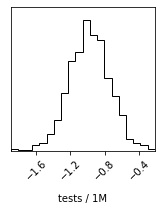

In [21]:
labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)

fig.show()

In [22]:
print('Active dimensions:', labs)

Active dimensions: ['tests / 1M']


## $\sigma = 2$

sample: 100%|██████████| 1500/1500 [00:16<00:00, 90.73it/s, 15 steps of size 2.64e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      2.44      2.99      1.50      0.18      5.22    287.63      1.00
 lambda[0]      9.06     51.43      2.00      0.09     10.76    760.67      1.00
 lambda[1]      7.16     27.73      1.75      0.03     11.49    453.99      1.00
 lambda[2]      4.79     16.03      1.52      0.04      7.71    480.56      1.01
 lambda[3]      4.31     19.32      1.25      0.00      6.25    583.66      1.00
 lambda[4]      3.23     27.43      0.39      0.00      3.61    541.72      1.00
 lambda[5]      8.17    156.43      0.55      0.00      3.59    917.13      1.00
 lambda[6]     25.53    304.24      1.91      0.10     13.32    423.86      1.00
 lambda[7]      5.26     15.30      1.59      0.02      9.18    588.46      1.00
 lambda[8]      8.98     49.45      1.40      0.04      8.15    270.28      1.00
 lambda[9]      8.71    223.48      0.14      0.00      1.10    930.10      1.00
lambda[10]      1.49      5

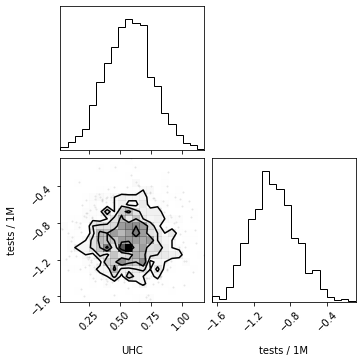

In [23]:
# Optimised hyperparameters
hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
          'sigma' : 2.0,
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754,   # this appears to be the key difference
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

skim_model = skim.SKIM(X, Y, hypers, seed=0)

all_active_dimensions, thetas, labels, pair_labs = skim_model.generate_posterior(known_active_dimensions=0, labels=short_labels)

labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)

fig.show()

In [24]:
print('Active dimensions:', labs)

Active dimensions: ['UHC', 'tests / 1M']


## $\sigma = 1.5$

sample: 100%|██████████| 1500/1500 [00:16<00:00, 91.92it/s, 15 steps of size 2.64e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      2.44      2.99      1.50      0.18      5.22    287.63      1.00
 lambda[0]      9.06     51.43      2.00      0.09     10.76    760.67      1.00
 lambda[1]      7.16     27.73      1.75      0.03     11.49    453.99      1.00
 lambda[2]      4.79     16.03      1.52      0.04      7.71    480.56      1.01
 lambda[3]      4.31     19.32      1.25      0.00      6.25    583.66      1.00
 lambda[4]      3.23     27.43      0.39      0.00      3.61    541.72      1.00
 lambda[5]      8.17    156.43      0.55      0.00      3.59    917.13      1.00
 lambda[6]     25.53    304.24      1.91      0.10     13.32    423.86      1.00
 lambda[7]      5.26     15.30      1.59      0.02      9.18    588.46      1.00
 lambda[8]      8.98     49.45      1.40      0.04      8.15    270.28      1.00
 lambda[9]      8.71    223.48      0.14      0.00      1.10    930.10      1.00
lambda[10]      1.49      5

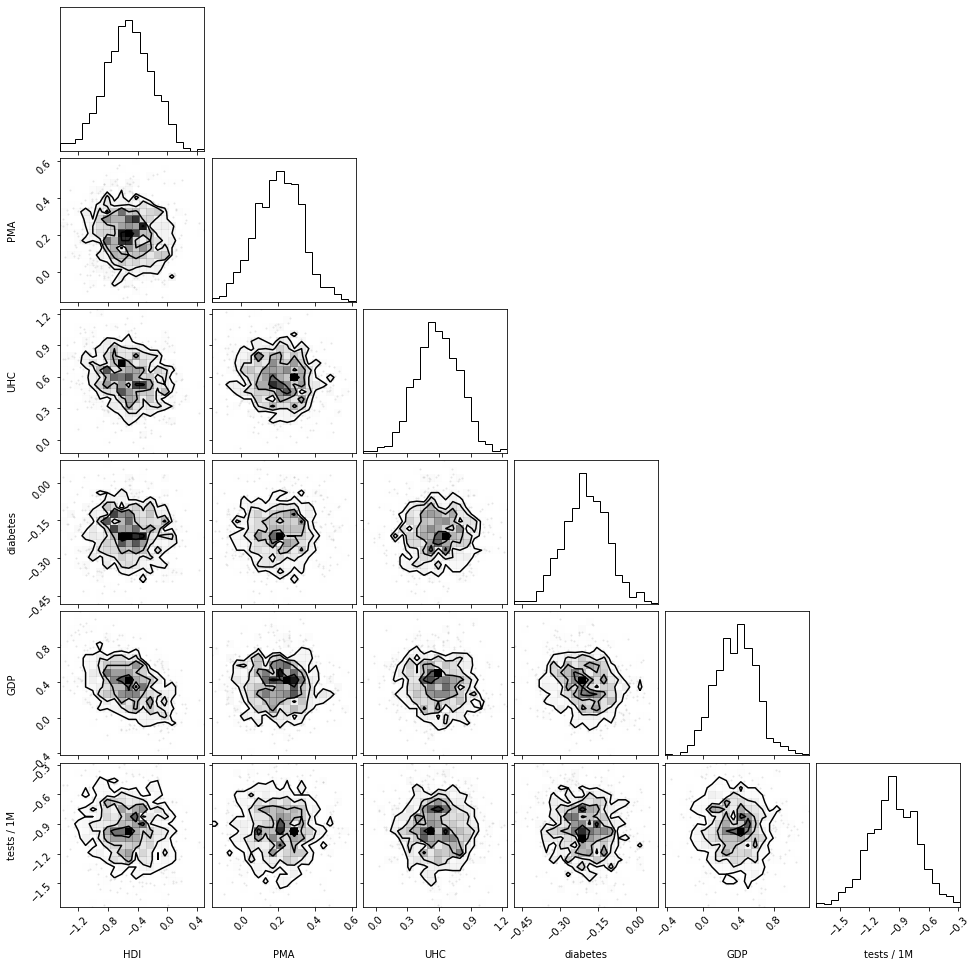

In [25]:
# Optimised hyperparameters
hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
          'sigma' : 1.5,
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754,   # this appears to be the key difference
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

skim_model = skim.SKIM(X, Y, hypers, seed=0)

all_active_dimensions, thetas, labels, pair_labs = skim_model.generate_posterior(known_active_dimensions=0, labels=short_labels)

labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)

fig.show()

In [26]:
print('Active dimensions:', labs)

Active dimensions: ['HDI', 'PMA', 'UHC', 'diabetes', 'GDP', 'tests / 1M']


## $\sigma = 1.0$

sample: 100%|██████████| 1500/1500 [00:16<00:00, 91.88it/s, 15 steps of size 2.64e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      2.44      2.99      1.50      0.18      5.22    287.63      1.00
 lambda[0]      9.06     51.43      2.00      0.09     10.76    760.67      1.00
 lambda[1]      7.16     27.73      1.75      0.03     11.49    453.99      1.00
 lambda[2]      4.79     16.03      1.52      0.04      7.71    480.56      1.01
 lambda[3]      4.31     19.32      1.25      0.00      6.25    583.66      1.00
 lambda[4]      3.23     27.43      0.39      0.00      3.61    541.72      1.00
 lambda[5]      8.17    156.43      0.55      0.00      3.59    917.13      1.00
 lambda[6]     25.53    304.24      1.91      0.10     13.32    423.86      1.00
 lambda[7]      5.26     15.30      1.59      0.02      9.18    588.46      1.00
 lambda[8]      8.98     49.45      1.40      0.04      8.15    270.28      1.00
 lambda[9]      8.71    223.48      0.14      0.00      1.10    930.10      1.00
lambda[10]      1.49      5

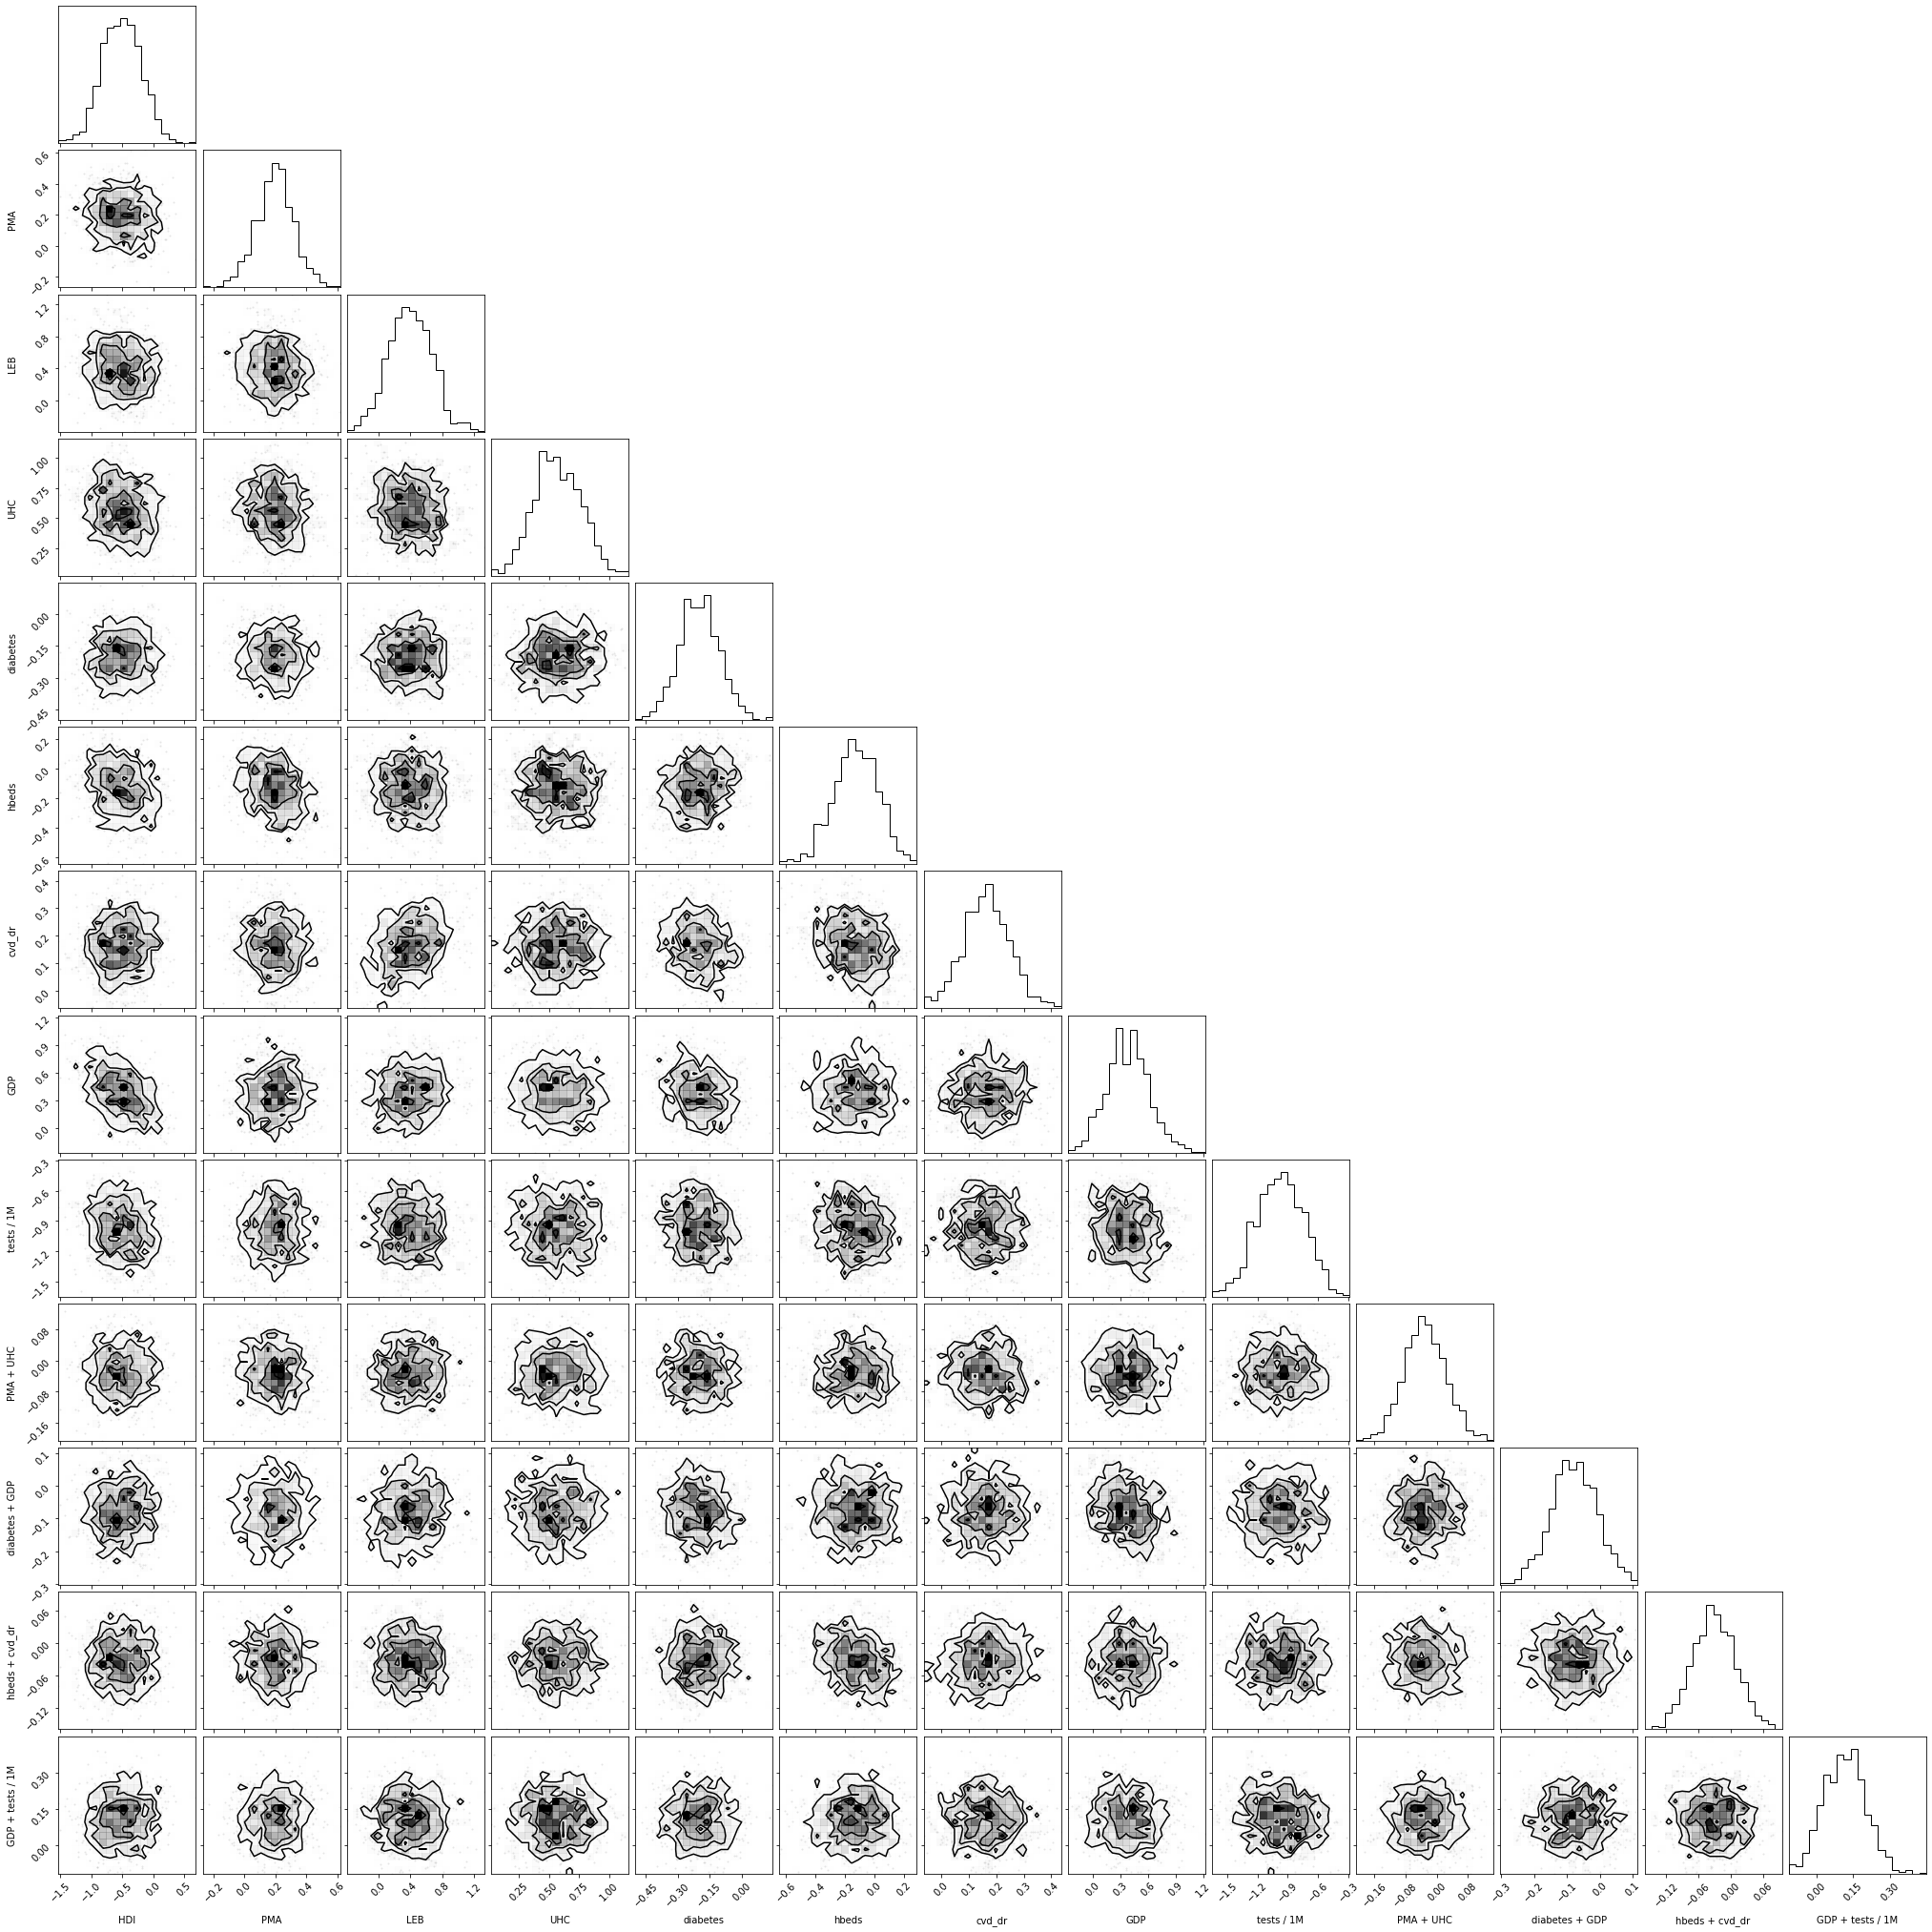

In [27]:
# Optimised hyperparameters
hypers = {'expected_sparsity': max(1.0, num_dimensions / 10),
          'sigma' : 1.0,
          'alpha1': 0.26872577050471647, 
          'alpha2': 4.818866884657901, 
          'alpha3': 6.812836016637205, 
          'alpha_obs': 49.093191654133754,   # this appears to be the key difference
          'beta1': 1.2942745182532156, 
          'beta2': 0.21267247881371867, 
          'beta_obs': 3.3406960438157594, 
          'c': 2.751017838090896}

skim_model = skim.SKIM(X, Y, hypers, seed=0)

all_active_dimensions, thetas, labels, pair_labs = skim_model.generate_posterior(known_active_dimensions=0, labels=short_labels)

labs = [short_labels[i] for i in all_active_dimensions if i <= len(short_labels)] + pair_labs
fig = corner.corner(thetas, labels = labs)

fig.show()

In [28]:
print('Active dimensions:', labs)

Active dimensions: ['HDI', 'PMA', 'LEB', 'UHC', 'diabetes', 'hbeds', 'cvd_dr', 'GDP', 'tests / 1M', 'PMA + UHC', 'diabetes + GDP', 'hbeds + cvd_dr', 'GDP + tests / 1M']


### Conclusion
From our exploratory COVID-19 study, we were able to recover several active factors in our assembled dataset that help explain case fatality in different countries around the world. Making use of our $\pm 1.5\sigma$ bound in the last plot, we see that intuitive factors, such as Human Development Index (HDI) and diabetes prevalence contribute to higher fatality. 

With the $\pm 1\sigma$ bound we identify 5 pairwise interactions and 9 singular interactions. What is interesting about this result is that we identify very frequent (2) interaction between the country's GDP per captia and other effects, hinting at an underlying *economic* explanation for otherwise poor health in those countries.

When we restrict our active dimension contour range to $\pm 2\sigma$, we recover just two active dimensions: the UHC health service coverage score and the availability of tests per 1 million people in the population. For a more comprehensive study, our data could be further weighted by the availability of tests, such that we do not recover biased fatality estimates from countries with more readily-available testing (unlike the US). 

***

***